In [1]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from PIL import Image

tfk = tf.keras
tfkl = tf.keras.layers

In [2]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [3]:
import warnings
import logging

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)
tf.get_logger().setLevel('INFO')
tf.autograph.set_verbosity(0)

tf.get_logger().setLevel(logging.ERROR)
tf.get_logger().setLevel('ERROR')
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

## Importing data

In [4]:
# Dataset folders 
dataset_dir = '/kaggle/input/an2dl-challenge-1-nt/data_splitted_no_test'
training_dir = os.path.join(dataset_dir, 'train')
validation_dir = os.path.join(dataset_dir, 'val')

In [5]:
# Images are divided into folders, one for each class. 
# If the images are organized in such a way, we can exploit the 
# ImageDataGenerator to read them from disk.
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create an instance of ImageDataGenerator, and for the trainign with Data Augmentation
train_data_gen = ImageDataGenerator(rotation_range=15, 
                                    height_shift_range=0.2, 
                                    width_shift_range=0.2, 
                                    zoom_range=0.2, 
                                    horizontal_flip=True, 
                                    shear_range=0.2, 
                                    fill_mode='reflect',
                                    rescale=1/255.) # rescale value is multiplied to the image ############################################
valid_data_gen = ImageDataGenerator(rescale=1/255.)

# Obtain a data generator with the 'ImageDataGenerator.flow_from_directory' method
train_gen = train_data_gen.flow_from_directory(directory=training_dir,
                                                       target_size=(96,96),
                                                       color_mode='rgb',
                                                       classes=None, # can be set to labels
                                                       class_mode='categorical',
                                                       batch_size=8,
                                                       shuffle=True,
                                                       seed=seed)

valid_gen = valid_data_gen.flow_from_directory(directory=validation_dir,
                                               target_size=(96,96),
                                               color_mode='rgb',
                                               classes=None, # can be set to labels
                                               class_mode='categorical',
                                               batch_size=8,
                                               shuffle=False,
                                               seed=seed)

Found 3648 images belonging to 8 classes.
Found 648 images belonging to 8 classes.


## Model

In [6]:
# to create a folder
import os
directory = "Inception"
parent_dir = "/kaggle/working"
path = os.path.join(parent_dir, directory)
os.mkdir(path)

In [7]:
!cd /kaggle/working/Inception

In [8]:
# Download and plot the ResNet152V2 model
inceptionv2 = tfk.applications.InceptionV3(
    include_top=False, # we are using only the conv part of the network, and not the FC part
    weights="imagenet",
    input_shape=(96,96,3)
)
inceptionv2.trainable = False # we are freezing the weights of the conv part, so that they are not updated
                            # during the training

87924736/87910968 [==============================] - 5s 0us/step


In [9]:
input_shape = (96, 96, 3)
epochs = 200

In [10]:
l1=1e-7
l2=1e-4

In [11]:
def inception(input_shape):

    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')
    
    #x = tfkl.Resizing(64, 64, interpolation="bicubic", name='resizing')(input_layer)
    inc = inceptionv2(input_layer)

    gap = tfkl.GlobalAveragePooling2D()(inc)
    drop1 = tfkl.Dropout(0.2, seed=seed)(gap)
    classifier_layer1 = tfkl.Dense(units=512, 
                                   name='Classifier1', 
                                   kernel_initializer=tfk.initializers.HeUniform(seed),
                                   kernel_regularizer=tfk.regularizers.L1L2(l1=l1, l2=l2))(drop1)
    act1 = tfkl.Activation("relu")(classifier_layer1)
    batch1 = tfkl.BatchNormalization()(act1)
    drop2 = tfkl.Dropout(0.2, seed=seed)(batch1)
    classifier_layer2 = tfkl.Dense(units=60, 
                                   name='Classifier2', 
                                   kernel_initializer=tfk.initializers.HeUniform(seed),
                                   kernel_regularizer=tfk.regularizers.L1L2(l1=l1, l2=l2))(drop2)
    act2 = tfkl.Activation("relu")(classifier_layer2)
    batch2 = tfkl.BatchNormalization()(act2)
    drop3 = tfkl.Dropout(0.2, seed=seed)(batch2)
    output_layer = tfkl.Dense(units=8, activation='softmax', kernel_initializer=tfk.initializers.GlorotUniform(seed), name='output_layer')(drop3)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.RMSprop(learning_rate=0.0001), metrics='accuracy')

    # Return the model
    return model

## Training

In [12]:
# Build model
IN = inception(input_shape)
IN.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 96, 96, 3)]       0         
_________________________________________________________________
inception_v3 (Functional)    (None, 1, 1, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
Classifier1 (Dense)          (None, 512)               1049088   
_________________________________________________________________
activation_94 (Activation)   (None, 512)               0         
_________________________________________________________________
batch_normalization_94 (Batc (None, 512)               2048  

In [13]:
# Train the model
IN_history = IN.fit(
    x = train_gen,
    batch_size = 256,
    epochs = 200,
    validation_data = valid_gen,
    #callbacks = callbacks,
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=30, restore_best_weights=True)],
).history

Epoch 1/200
456/456 [==============================] - 52s 91ms/step - loss: 2.5849 - accuracy: 0.1900 - val_loss: 2.0228 - val_accuracy: 0.2994
Epoch 2/200
456/456 [==============================] - 19s 41ms/step - loss: 2.3156 - accuracy: 0.2552 - val_loss: 1.8612 - val_accuracy: 0.3596
Epoch 3/200
456/456 [==============================] - 19s 42ms/step - loss: 2.1571 - accuracy: 0.2876 - val_loss: 1.7570 - val_accuracy: 0.3935
Epoch 4/200
456/456 [==============================] - 18s 39ms/step - loss: 2.0831 - accuracy: 0.3100 - val_loss: 1.7036 - val_accuracy: 0.4090
Epoch 5/200
456/456 [==============================] - 18s 40ms/step - loss: 2.0193 - accuracy: 0.3188 - val_loss: 1.6765 - val_accuracy: 0.4090
Epoch 6/200
456/456 [==============================] - 18s 39ms/step - loss: 1.9727 - accuracy: 0.3273 - val_loss: 1.6274 - val_accuracy: 0.4213
Epoch 7/200
456/456 [==============================] - 18s 40ms/step - loss: 1.9389 - accuracy: 0.3342 - val_loss: 1.5858 - val_ac

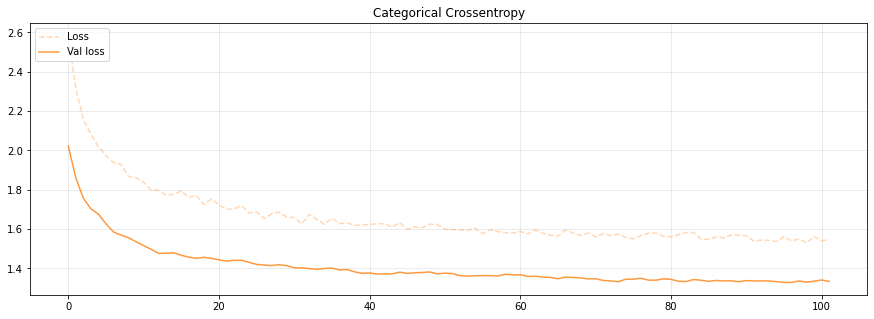

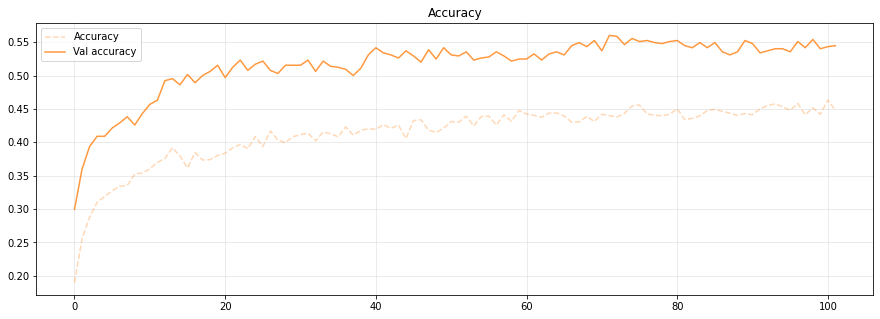

In [14]:
# Plot the training
plt.figure(figsize=(15,5))
plt.plot(IN_history['loss'], label='Loss', alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(IN_history['val_loss'], label='Val loss', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)
plt.savefig('IN_v1.2.1_loss.png')

plt.figure(figsize=(15,5))
plt.plot(IN_history['accuracy'], label='Accuracy', alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(IN_history['val_accuracy'], label='Val accuracy', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)
plt.savefig('IN_v1.2.1_acc.png')

plt.show()

In [15]:
# Save the best model
IN.save('IN_v1.2.1')

In [16]:
# Evaluate on val
val_metrics = IN.evaluate(valid_gen, return_dict=True)

print()
print("Val metrics")
print(val_metrics)

81/81 [==============================] - 2s 22ms/step - loss: 1.3391 - accuracy: 0.5602

Val metrics
{'loss': 1.339092493057251, 'accuracy': 0.5601851940155029}


In [17]:
import shutil
#shutil.make_archive("IN_v1.1.4", 'zip', "/kaggle/working/IN_v1.1.4")

## Fine tuning